# Import Dependencies

In [1]:
import os
import numpy
import gdown
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Input, InputLayer, Conv2D, MaxPooling2D, Dropout, Flatten, Resizing, Dense, GlobalAveragePooling2D,
                                     BatchNormalization, RandomRotation, RandomFlip, RandomContrast, Rescaling)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

import warnings
warnings.filterwarnings("ignore")

cls()

In [2]:
# URL file Google Drive
# https://drive.google.com/file/d/1AglUWOtNttLKFZAvW4zKK5BHoC0WCXMy/view?usp=sharing
url = 'https://drive.google.com/uc?id=1AglUWOtNttLKFZAvW4zKK5BHoC0WCXMy'
output = 'data.zip'

# Mengunduh file
gdown.download(url, output, quiet=False)

from zipfile import ZipFile

# Ekstrak file ZIP
with ZipFile(file="/content/data.zip", mode='r') as Zfile:
    Zfile.extractall(path="content/data")
cls()

In [3]:
dataset_dir = 'content/data/'
x = 0
CLASS_NAMES = []
for buah in os.listdir(dataset_dir):
  print(f'{buah}\t\t=> {len(os.listdir(dataset_dir+buah))}')
  x += len(os.listdir(dataset_dir+buah))
  CLASS_NAMES.append(buah)
print(f'Total Images : {x}')
print(f'Total Class : {len(CLASS_NAMES)}')
print(f'Class Image => {CLASS_NAMES}')

sayurLabuSiam		=> 199
buahAnggur		=> 272
daunParsley		=> 200
buahSalak		=> 225
labuWaluhKuning		=> 202
sayurJagungMuda		=> 219
buahJeruk		=> 206
buahNanas		=> 196
bayamHijau		=> 207
sayurKecipir		=> 203
buahJerukBali		=> 190
sayurKolMerah		=> 203
buahMatoa		=> 203
sayurKolPutih		=> 180
buahSrikaya		=> 225
bayamMerah		=> 202
buahKesemek		=> 204
buahDurian		=> 235
buahManggis		=> 229
petai		=> 240
sayurSeladaAir		=> 185
jamurKuping		=> 185
buahSukun		=> 201
buahJambuAir		=> 225
buahJambuBiji		=> 210
buahBelimbing		=> 200
buahKelapa		=> 214
rumputLaut		=> 180
sayurPepayaMuda		=> 200
melinjo		=> 212
buahLemon		=> 212
buahMarkisa		=> 225
sayurSawiPutih		=> 198
buahRambutan		=> 207
sayurGenjer		=> 200
buahKedondong		=> 200
buahAlpukat		=> 202
buahKelengkeng		=> 195
buahMengkudu		=> 219
taoge		=> 179
sayurPakis		=> 180
buahDuku		=> 198
kacangMekah		=> 200
sayurNangkaMuda		=> 206
buahApel		=> 197
timun		=> 215
wortel		=> 197
rebung		=> 200
sayurTerongBelanda		=> 200
daunTalas		=> 190
buahPala	

# Processing

In [4]:
CONFIGURATION = {
    'VALIDATION' : 0.2,
    'BATCH_SIZE' : 32,
    'IM_SIZE' : 224,
    'LEARNING_RATE' : 1e-3,
    'N_EPOCHS' : 50,
    'DROPOUT_RATE' : 0.25,
    'REGULARIZATION_RATE' : 0.01,
    'N_FILTERS' : 6,
    'KERNEL_SIZE' : 5,
    'N_STRIDES' : 1,
    'POOL_SIZE' : 2,
    'N_DENSE_1' : 128,
    'N_DENSE_2' : 32,
    'NUM_CLASSES' : len(CLASS_NAMES),
    'CLASS_NAMES' : CLASS_NAMES,
}

train_data = tf.keras.utils.image_dataset_from_directory(
    '/content/content/data',
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CONFIGURATION['CLASS_NAMES'],
    color_mode = 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle = True,
    seed = 100,
    subset = "training",
    validation_split = CONFIGURATION['VALIDATION']
    )

val_data = tf.keras.utils.image_dataset_from_directory(
    '/content/content/data',
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = CONFIGURATION['CLASS_NAMES'],
    color_mode = 'rgb',
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle = True,
    seed = 200,
    subset = "validation",
    validation_split = CONFIGURATION['VALIDATION']
    )

Found 16012 files belonging to 78 classes.
Using 12810 files for training.
Found 16012 files belonging to 78 classes.
Using 3202 files for validation.


In [5]:
# split val_data to data validation and data test
datasize = len(val_data)
valratio = 0.9
testratio = 0.1

test_data = val_data.skip(int((valratio)*datasize))
val_data = val_data.take(int(valratio*datasize))
print(len(train_data))
print(datasize)
print(len(val_data))
len(test_data)

401
101
90


11

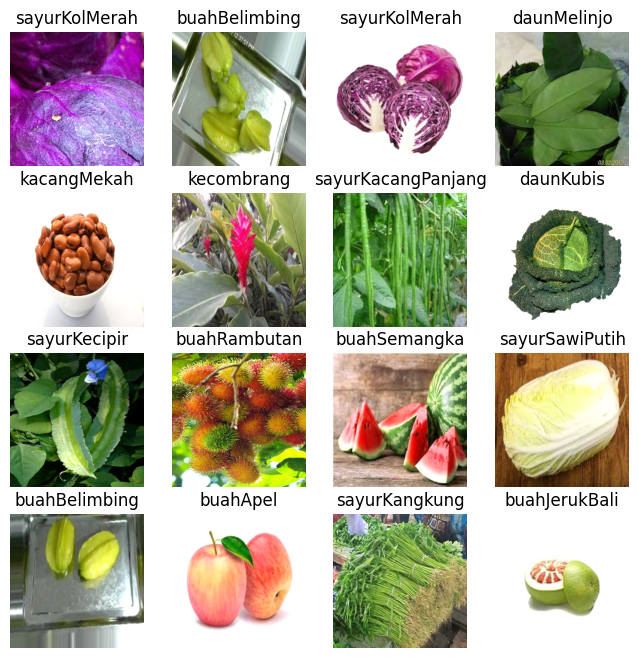

In [6]:
plt.figure(figsize = (8,8))
for image,label in test_data.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(image[i]/225)
    plt.title(CONFIGURATION['CLASS_NAMES'][tf.argmax(label[i], axis=0).numpy()])
    plt.axis('off')
plt.show()

In [7]:
augment_layer = tf.keras.Sequential([
    RandomFlip(mode='horizontal'),
    RandomRotation(0.2),
    RandomContrast(0.2),
    Rescaling(1./255.)
])

def augment_layers(image, label):
    return augment_layer(image, training=True), label

# rescale_layer = tf.keras.Sequential([Rescaling(1./127.5, offset=-1)])

# def rescale_layers(image, label):
    # return rescale_layer(image, training=True), label

train_dataset = (
    train_data
    .map(augment_layers, num_parallel_calls = tf.data.AUTOTUNE)
    .cache().prefetch(tf.data.AUTOTUNE))

val_dataset = (
    val_data
    # .map(augment_layers, num_parallel_calls = tf.data.AUTOTUNE)
    .cache().prefetch(tf.data.AUTOTUNE))

test_dataset = (
    test_data
    # .map(augment_layers, num_parallel_calls = tf.data.AUTOTUNE)
    .cache().prefetch(tf.data.AUTOTUNE))

# MobileNetV3Large

In [8]:
backbone = tf.keras.applications.MobileNetV3Large(
    input_shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3),
    include_top=False,
    weights='imagenet',
    # include_preprocessing=False
)
backbone.trainable = False
cls()

# inputs = tf.keras.Input(shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3))
# x = augment_layer(inputs)
# x = rescale_layer(x)
# x = backbone(x, training=False)
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.10)(x)
# x = Dense(CONFIGURATION['N_DENSE_1'], activation = 'relu')(x)
# x = BatchNormalization()(x)
# outputs = Dense(CONFIGURATION['NUM_CLASSES'], activation = 'softmax')(x)
# MobNet = tf.keras.Model(inputs, outputs, name='MobNet-SehatIn')


MobNet = tf.keras.Sequential([
    # InputLayer((CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3)),
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    Dropout(0.10),
    Dense(CONFIGURATION['N_DENSE_1'], activation = 'relu'),
    BatchNormalization(),
    Dense(CONFIGURATION['NUM_CLASSES'], activation = 'softmax')
    ], name='MobNet-SehatIn')

MobNet.summary()

Model: "MobNet-SehatIn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 128)               123008    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                    

In [9]:
loss_func = CategoricalCrossentropy()
metrics = [CategoricalAccuracy(name = 'accuracy')]

MobNet.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.025),
    loss = loss_func,
    metrics = metrics
)

early_stopping = EarlyStopping(monitor='val_accuracy',
                               restore_best_weights = True,
                               patience=3)

class MyStop(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs['accuracy']>0.92 and logs['val_accuracy']>0.92 and logs['loss']<0.9 and logs['val_loss']<0.9:
            print('\nModel well fitting')
            self.model.stop_training=True
mystop = MyStop()

early_stopping = EarlyStopping(monitor='val_accuracy',
#                                min_delta=0.01,
                               restore_best_weights = True,
                               patience=5)

history = MobNet.fit(
    train_data, validation_data = val_dataset,
    epochs = CONFIGURATION['N_EPOCHS']*2,
    verbose = 1, callbacks = [early_stopping]
)

Epoch 1/100
401/401 [==============================] - 75s 162ms/step - loss: 1.3097 - accuracy: 0.6448 - val_loss: 0.7137 - val_accuracy: 0.7941
Epoch 2/100
401/401 [==============================] - 46s 113ms/step - loss: 0.7132 - accuracy: 0.7952 - val_loss: 0.5521 - val_accuracy: 0.8403
Epoch 3/100
401/401 [==============================] - 46s 112ms/step - loss: 0.5807 - accuracy: 0.8294 - val_loss: 0.4483 - val_accuracy: 0.8788
Epoch 4/100
401/401 [==============================] - 46s 113ms/step - loss: 0.4972 - accuracy: 0.8528 - val_loss: 0.3752 - val_accuracy: 0.8958
Epoch 5/100
401/401 [==============================] - 46s 113ms/step - loss: 0.4529 - accuracy: 0.8636 - val_loss: 0.3951 - val_accuracy: 0.8924
Epoch 6/100
401/401 [==============================] - 46s 114ms/step - loss: 0.4014 - accuracy: 0.8820 - val_loss: 0.3964 - val_accuracy: 0.8878
Epoch 7/100
401/401 [==============================] - 50s 122ms/step - loss: 0.3729 - accuracy: 0.8868 - val_loss: 0.4505 -

In [10]:
loss, acc = MobNet.evaluate(test_dataset)

11/11 [==============================] - 10s 123ms/step - loss: 0.3177 - accuracy: 0.9286


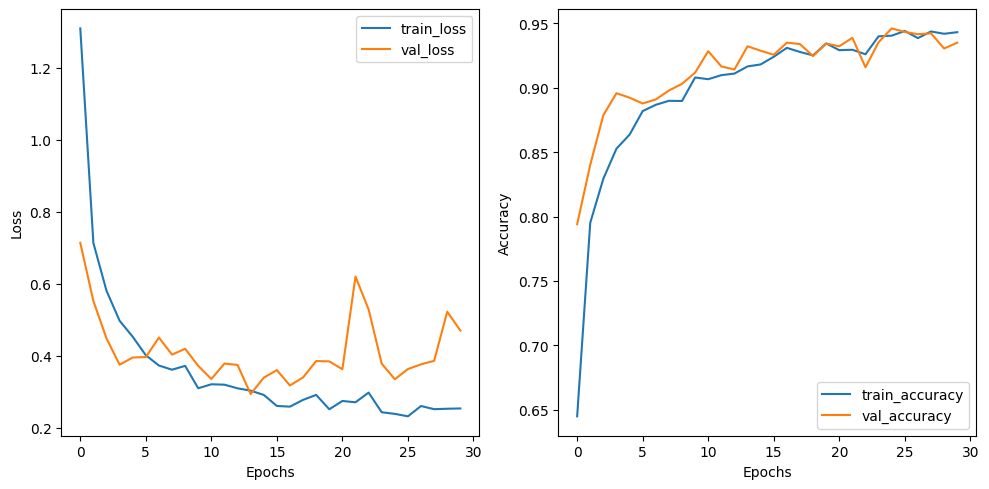

In [11]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])

plt.tight_layout()
plt.show()

In [13]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [15]:
MobNetJSON = MobNet.to_json()
with open (f'/content/drive/MyDrive/dicoding /MobNetV3L[0,1]{int(round(acc,2)*100)}_1.json', 'w') as writer:
    writer.write(MobNetJSON)

MobNet.save(f'/content/drive/MyDrive/dicoding /MobNetV3L[0,1]{int(round(acc,2)*100)}_1.keras')

MobNet.save(f'/content/drive/MyDrive/dicoding /MobNetV3L[0,1]{int(round(acc,2)*100)}_1.h5')

# ===============================================================================================================

converter = tf.lite.TFLiteConverter.from_keras_model(MobNet)
tflite_model = converter.convert()

tflite_path = '/content/drive/MyDrive/dicoding /MobNetV3L[0,1].tflite'
with open(tflite_path, 'wb') as lite:
  lite.write(tflite_model)

In [16]:
plt.figure(figsize=(15,15))
for image,label in test_dataset.take(1):
  for i in range(16):
    actuall = CLASS_NAMES[tf.argmax(label[i], axis=0).numpy()]
    presentase = round(round(tf.reduce_max(MobNet.predict(tf.expand_dims(image[i], axis=0), verbose=0), axis=1).numpy()[0], 2)*100, 2)
    pred = CLASS_NAMES[tf.argmax(MobNet.predict(tf.expand_dims(image[i], axis=0), verbose=0), axis=1).numpy()[0]]
    plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255)
    plt.title(f'True : {actuall}\nPredicted {presentase}% as {pred} ')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## FineTunning

In [18]:
for layer in backbone.layers[-30:]:  # Unfreeze the last 50 layers
    layer.trainable = True

# Compile the model again
MobNet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIGURATION['LEARNING_RATE'] / 10),  # Lower learning rate for fine-tuning
    loss=loss_func,
    metrics=metrics
)

class MyStop(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs['accuracy']>0.95 and logs['val_accuracy']>0.97:
            print('\nModel well fitting')
            self.model.stop_training=True
mystop = MyStop()

# Fine-tuning
history_fine_tune = MobNet.fit(
    train_data,
    validation_data=val_data,
    epochs=CONFIGURATION['N_EPOCHS'],
    verbose=1,
    callbacks=[mystop]
)

Epoch 1/50
401/401 [==============================] - 73s 166ms/step - loss: 1.1686 - accuracy: 0.7999 - val_loss: 0.4921 - val_accuracy: 0.9017
Epoch 2/50
401/401 [==============================] - 54s 133ms/step - loss: 1.0692 - accuracy: 0.8162 - val_loss: 0.5282 - val_accuracy: 0.8944
Epoch 3/50
401/401 [==============================] - 65s 162ms/step - loss: 1.0173 - accuracy: 0.8195 - val_loss: 0.5231 - val_accuracy: 0.8955
Epoch 4/50
401/401 [==============================] - 55s 136ms/step - loss: 0.9950 - accuracy: 0.8250 - val_loss: 0.5422 - val_accuracy: 0.8896
Epoch 5/50
401/401 [==============================] - 55s 136ms/step - loss: 0.9211 - accuracy: 0.8296 - val_loss: 0.5246 - val_accuracy: 0.8931
Epoch 6/50
401/401 [==============================] - 56s 137ms/step - loss: 0.9134 - accuracy: 0.8326 - val_loss: 0.5333 - val_accuracy: 0.8938
Epoch 7/50
401/401 [==============================] - 55s 135ms/step - loss: 0.8423 - accuracy: 0.8390 - val_loss: 0.5234 - val_ac

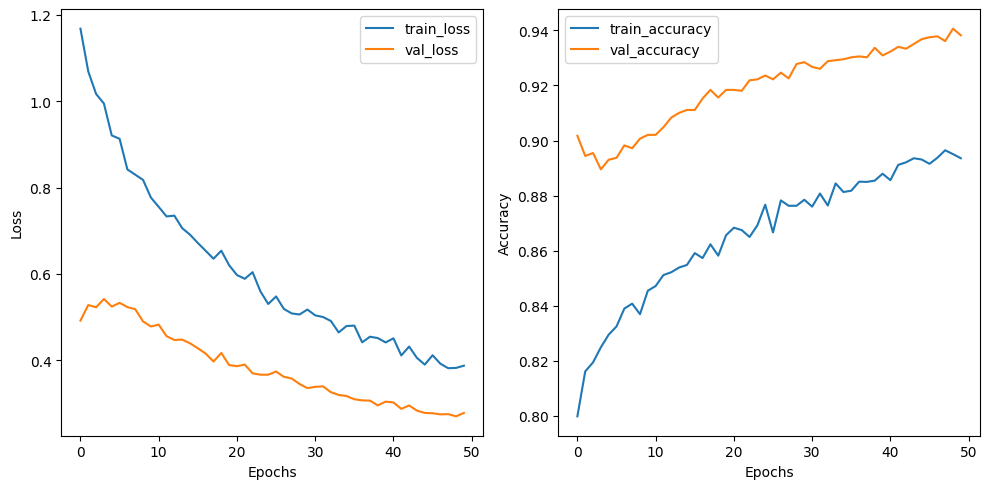

In [19]:
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(history_fine_tune.history['loss'])
plt.plot(history_fine_tune.history['val_loss'])
# plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train_loss', 'val_loss'])

plt.subplot(1,2,2)
plt.plot(history_fine_tune.history['accuracy'])
plt.plot(history_fine_tune.history['val_accuracy'])
# plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])

plt.tight_layout()
plt.show()

In [20]:
val, acc = MobNet.evaluate(test_dataset)

11/11 [==============================] - 0s 39ms/step - loss: 0.2639 - accuracy: 0.9441


In [21]:
MobNetJSON = MobNet.to_json()
with open (f'/content/drive/MyDrive/dicoding /MobNetV3L(after fine tuning)[0,1]{int(round(acc,2)*100)}_2.json', 'w') as writer:
    writer.write(MobNetJSON)

MobNet.save(f'/content/drive/MyDrive/dicoding /MobNetV3L(after fine tuning)[0,1]{int(round(acc,2)*100)}_2.keras')

MobNet.save(f'/content/drive/MyDrive/dicoding /MobNetV3L(after fine tuning)[0,1]{int(round(acc,2)*100)}_2.h5')


# ==========================================================================
# model_h5 = '/content/drive/MyDrive/Capstone/model[-1,1]/MobNetV3L.h5'
# model = tf.keras.models.load_model(model_h5)

converter = tf.lite.TFLiteConverter.from_keras_model(MobNet)
tflite_model = converter.convert()

tflite_path = '/content/drive/MyDrive/dicoding /MobNetV3L(after fine tuning)[0,1].tflite'
with open(tflite_path, 'wb') as lite:
  lite.write(tflite_model)


In [22]:
plt.figure(figsize=(15,15))
for image,label in test_dataset.take(1):
  for i in range(16):
    actuall = CLASS_NAMES[tf.argmax(label[i], axis=0).numpy()]
    presentase = int(round(tf.reduce_max(MobNet.predict(tf.expand_dims(image[i], axis=0), verbose=0), axis=1).numpy()[0], 2)*100)
    pred = CLASS_NAMES[tf.argmax(MobNet.predict(tf.expand_dims(image[i], axis=0), verbose=0), axis=1).numpy()[0]]
    plt.subplot(4,4,i+1)
    plt.imshow(image[i]/255)
    plt.title(f'True : {actuall}\nPredicted {presentase}% as {pred} ')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

Output hidden; open in https://colab.research.google.com to view.